# Causal probabilistic programming without tears

Despite the tremendous progress over the last several decades in reducing
causal inference to statistical practice, the \"causal revolution\"
proclaimed by Judea Pearl and others remains incomplete, with a sprawling and
fragmented literature inaccessible to non-experts and still somewhat
isolated from cutting-edge machine learning research and software tools.

Functional probabilistic programming languages are promising substrates for bridging this gap thanks to the close correspondence between their operational semantics and the field’s standard mathematical formalism of structural causal models. 

In this tutorial we elaborate on this idea with three key observations inspiring Causal Pyro's design, and outline a causal Bayesian workflow for using Causal Pyro to answer causal questions.

## Observation 1: causal models are probabilistic programs

Probabilistic programmers typically think of their code as defining a
probability distribution over a set of variables, but programs often contain
more information than just the joint distributions they induce. In practice,
when we write probabilistic programs in languages like Pyro we often bring
to bear knowledge of causal relationships between variables, and implicitly,
how changes to one variable would propagate to changes in others.

Formally, a causal model specifies a *family* of probability
distributions, indexed by a set of *interventions*. An intervention
represents a hypothetical change to the domain, under which we'd
expect the joint distribution over the variables of interest to change.

To ground this out a bit more concretely, consider the following Pyro program
describing the joint distribution over three random variables, *stress*, *smokes*,
and *cancer*. We'll call this model an `observational_model` for reasons that will
become apparent when we want to reason about cause and effect later.

In [87]:
import pyro
import torch
from pyro.distributions import Bernoulli

def observational_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

Our `observational_model` takes as input three sets of parameters, here just marginal and conditional probability tables, 
and returns a sample from the joint distribution over a single individual's *stress*, *smokes*, and *cancer* attributes.

Using Pyro's `plate` effect handler, we can easily sample repeatedly from the `observational_model`
to yield a joint distribution of an entire population of individual's attributes. For now we'll just 
choose some parameters by hand, but later we'll see how we can use Pyro's inference to infer likely
parameters from data.

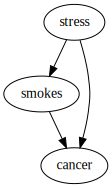

In [88]:
stress_pt = torch.tensor([0.5])
smokes_cpt  = torch.tensor([0.2, 0.8])
cancer_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

n_individuals = 10000
with pyro.plate("individuals", n_individuals, dim=-1):
    stress_obs, smokes_obs, cancer_obs = observational_model(stress_pt, smokes_cpt, cancer_cpt)

pyro.render_model(observational_model, (stress_pt, smokes_cpt, cancer_cpt))

Let's pretend for a moment that we're only interested in the relationship between whether individuals smoke
and how likely they are to get cancer. To understand this relationship a bit better, we can visualize the simulation from our model.

[Text(0.5, 1.0, 'Observational Data')]

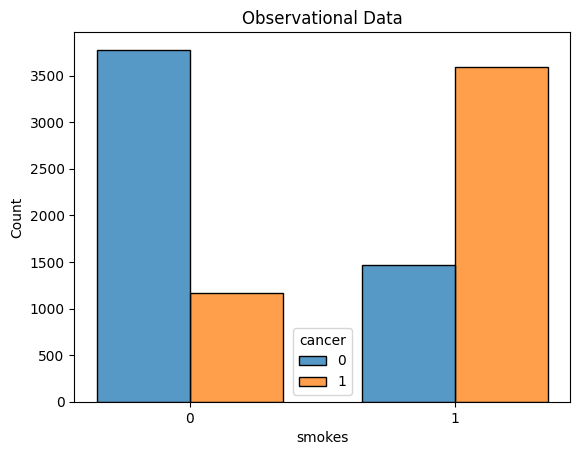

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_obs = torch.concat((stress_obs.reshape(-1, 1), smokes_obs.reshape(-1, 1), cancer_obs.reshape(-1, 1)), axis=-1)

frame_obs = pd.DataFrame(data_obs.numpy(), columns=["stressed", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})

sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs).set(title='Observational Data')

As we can see clearly, our model tells us that individuals who smoke are much more likely to get cancer than individuals
who don't. Of the ~7,000 simulated individuals who don't smoke only ~500 got cancer, roughly 7% of the non-smokers. Of the 
remaining ~3,000 simulated individuals who did smoke ~1,000 individuals got cancer, a much high 33% of the smoking population.

(TODO: edit these numbers once parameters are finalized. They've already drifted from the figures because I was playing with parameters to tell the story.)

So far we have a program that describes the distribution over data given model parameters. 
Somewhat more abstractly, we can imagine this process of simulating from a model as we've done above
with the following (somewhat cartoonish) diagram. Here, each point in "model space" or "parameter space"
induces a joint distribution over data.

(TODO: replace SCM with "program" and change colors a bit.)

![title](figures/Conditional_Distribution_of_Data.png)

Simulating from our `observational_model` is certainly interesting and (perhaps) informative, but it doesn't exactly give us answers to what what we're interested in. Instead, we want to
know to what extent smoking *causes* cancer, not just it's predictive ability. To answer this question, we can instead
sample from modified versions of our model in which individuals are forced to smoke or not smoke, regardless of their level of stress. We can instatiate these thought experiments
as new programs in our probabilistic programming language.

To ground this out a bit more concretely, consider the following two new Pyro programs; 
`always_smokes_model` and `never_smokes_model`, which closely resemble our original `observational_model` except 
in how the *smokes* attribute is assigned. Specifically, we've replaced the expression `smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()`
with the expressions `smokes   = pyro.deterministic("smokes", torch.ones_like(stress))` and `smokes   = pyro.deterministic("smokes", torch.zeros_like(stress))` respectively.
In other words, we set the *smokes* variable to be either $1$ or $0$ regardless of the individual's stress.

In [72]:
def always_smokes_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    # smokes no longer depends on stress.
    smokes   = pyro.deterministic("smokes", torch.ones_like(stress))
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

def never_smokes_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    # smokes no longer depends on stress.
    smokes   = pyro.deterministic("smokes", torch.zeros_like(stress))
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

# Let's pretend that we force half the people to always smoke and half to never smoke.
n_counterfactual_individuals = int(n_individuals/2)
with pyro.plate("counterfactual_individuals", n_counterfactual_individuals, dim=-1):
    # Sample from a population of individuals under the "always smokes" thought experiment.
    stress_as, smokes_as, cancer_as = always_smokes_model(stress_pt, smokes_cpt, cancer_cpt)
    stress_ns, smokes_ns, cancer_ns = never_smokes_model(stress_pt, smokes_cpt, cancer_cpt)

Let's visualize a simulation from these new programs and compare against our original simulation.

[Text(0.5, 1.0, 'Thought Experiment')]

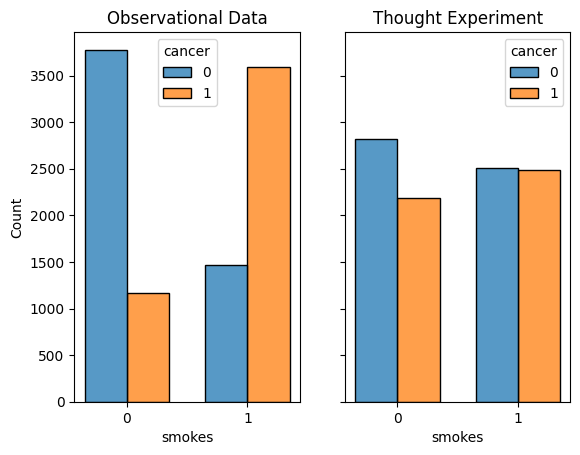

In [73]:
data_as = torch.concat((stress_as.reshape(-1, 1), smokes_as.reshape(-1, 1), cancer_as.reshape(-1, 1)), axis=-1)
data_ns = torch.concat((stress_ns.reshape(-1, 1), smokes_ns.reshape(-1, 1), cancer_ns.reshape(-1, 1)), axis=-1)
data_int = torch.concat((data_as, data_ns))

frame_int = pd.DataFrame(data_int.numpy(), columns=["stressed", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})

_, ax = plt.subplots(1, 2, sharey=True)

sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs, ax=ax[0]).set(title='Observational Data')
sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_int, ax=ax[1]).set(title='Thought Experiment')


Using our intervened models we can clearly see that changing the mechanism by which individuals
choose whether or not to smoke dramatically changes the joint distribution between smoking and cancer. In our observational model
individuals who smoke are much more likely to get cancer than those who don't smoke. However, in our modified model in which individuals
are forced to smoke or not smoke, the dependence between smoking and cancer nearly disapears.

This phenomenon we're observing in this (contrived) example is known as confounding. Here, the reason we see a statistical dependency between
smoking in cancer in our observational model is because of the individuals' stress. Individuals who are stressed are more likely to smoke, and stress
causes an increase in cancer. The confounding effect of stress dissapears in our intervened programs, as stress no longer influences whether individuals smoke or not.

Before we move on, let's be a bit more precise about the causal query we'd like to answer. One quantity we may wish to estimate is how much, on average, smoking increases the risk of cancer.
We can define this *average treatment effect* mathematically as the difference between the proportion of individuals who get cancer under our `always_smokes_model` and our `never_smokes_model`.
Again, we can easily write this as code.

In [74]:
effect = cancer_as.float().mean() - cancer_ns.float().mean()
effect

tensor(0.0612)

So far, we've defined a model describing how data is generated in the actual world we can observe, which we called `observational_model`, and then transformed
our original model to represent our thought experiments, or interventions, which we called `always_smokes_model` and `never_smokes_model`. Then, we sampled
from our original and transformed models to generate simulated outcomes, and finally summarized the simulated outcomes yielding an answer to our causal query. Again,
this process can be viewed somewhat abstractly as follows:

![title](figures/Interventional_Conditional.png)


One of the key insights behind Causal Pyro (and borrowed from Pearl's structural formalism) is that these kinds of interventions can be formalized as model agnostic
program transformations, i.e. a function $I: \mathcal{P} \rightarrow \mathcal{P}$, where $\mathcal{P}$ is the space of programs in our language.

Thusfar we've accomplished some limited form of causal reasoning by manually rewriting our original program, replacing the mechanism for how individuals choose to smoke directly in Pyro's syntax, and then simulating from the new programs.
This is a perfectly reasonable thing to do in these kinds of simple scenarios where we have a single model and a single "thought experiment" we want to explore. However, as we'll see throughout these tutorials and examples,
reasoning about cause and effect can often involve much more involved program transformations than this simple example. For example, in our mediation analysis example (TODO: add pointer to example) we'll need to simulate
multiple counterfactual models simultaneously, with intervention assignments in one that depend on simulated outcomes in another. 

Instead, Causal Pyro addresses the complexity of causal reasoning by automating a number of probabilistic program transformations; including
interventions, construction of counterfactual worlds, and (as we'll see in subsequent tutorials) automatic reparameterization for counterfactual or "what if" reasoning. 

For example, we can much more succinctly implement `always_smokes_model` and `never_smokes_model` succinctly as follows, using Causal Pyro's `do` program transformation.
This special function `do` takes as input a probabilistic program and a dictionary describing the intervention assignment and returns a transformed probabilistic program with the intervention applied.

In [75]:
from causal_pyro.query.do_messenger import do

always_smokes_model = do(observational_model, {"smokes": torch.tensor([1.])})
never_smokes_model  = do(observational_model, {"smokes": torch.tensor([0.])})

Just like our original implementation of `always_smokes_model` and `never_smokes_model`, these transformed models are probabilistic programs in Pyro, and can thus freely compose with all of Pyro's effect handlers.
For example, we can again use an `plate` effect handler to sample from a population of individuals.

In [76]:
with pyro.plate("counterfactual_individuals", n_counterfactual_individuals, dim=-1):
    # Sample from a population of individuals under the "always smokes" thought experiment.
    stress_as, smokes_as, cancer_as = always_smokes_model(stress_pt, smokes_cpt, cancer_cpt)
    stress_ns, smokes_ns, cancer_ns = never_smokes_model(stress_pt, smokes_cpt, cancer_cpt)

effect = cancer_as.float().mean() - cancer_ns.float().mean()
effect

tensor(0.0418)

In this section we've seen that a probabilistic program specifies a causal model in that it
  1. specifies a "default" or "observational" joint distribution over the
variables of interest according to the usual semantics of probabilistic
programming languages
  2. encodes the necessary information to
determine the new joint distribution under an arbitrary intervention
(program transformation)---apply the transformation and derive the new
joint distribution.


## Observation 2: causal uncertainty is probabilistic uncertainty

So far we've shown how to define a causal model as a probabilistic program, and how to use Causal Pyro's intervention program transformations, `do`,
to answer causal questions. However, in doing so we made a few very strong assumptions.

1. We assumed that we knew the parameters of our causal model exactly, i.e. we asserted *how much* variables causally affect which other variables.
2. We assumed that we knew the structure of our causal model exactly, i.e. we asserted *which* variables causally affect which other variables.

In this section we'll show how we can use Causal Pyro to substantially relax these assumptions, representing broad uncertainty over causal structure and parameters.

Mathematically, the `observational_model` we defined previously can be thought of as a programatic representation of the conditional distribution $P(stress, smokes, cancer | \theta)$, where $\theta$ 
represents all of the parameters taken as arguments. To instead represent the joint distribution $P(stress, smokes, cancer, \theta)$ we can simply define a program representing the prior $P(\theta)$
and then call our `observational_model` using samples from the prior program as follows.

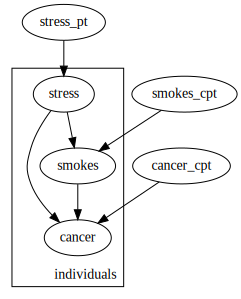

In [114]:
from pyro.distributions import Beta

def parameter_prior():

    stress_pt = pyro.sample("stress_pt", Beta(torch.ones(1), torch.ones(1)))
    smokes_cpt = pyro.sample("smokes_cpt", Beta(torch.ones(2), torch.ones(2)))
    cancer_cpt = pyro.sample("cancer_cpt", Beta(torch.ones(2, 2), torch.ones(2, 2))) 

    return stress_pt, smokes_cpt, cancer_cpt

def bayesian_observational_model(n_individuals):
    stress_pt, smokes_cpt, cancer_cpt = parameter_prior()

    with pyro.plate("individuals", n_individuals, dim=-1):
        # Call our original observational_model with parameters sampled from our prior above.
        return observational_model(stress_pt, smokes_cpt, cancer_cpt)

pyro.render_model(bayesian_observational_model, (n_individuals,))

By repeatedly sampling from the observational model we can see how our new uncertainty about probability tables propagates to uncertainty about the relationship between smoking and cancer.

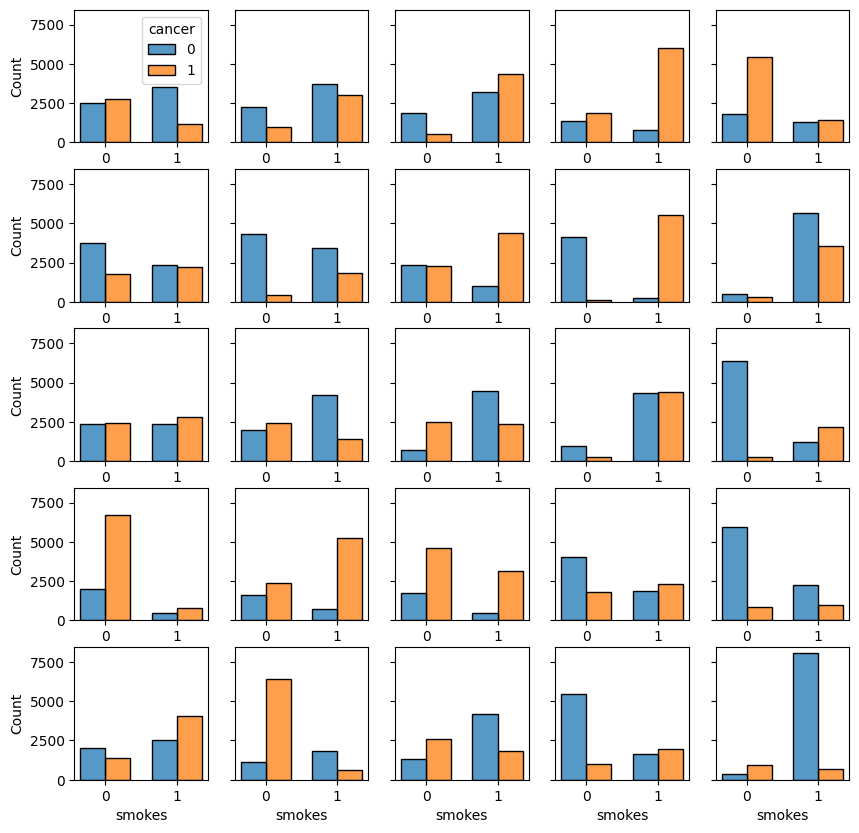

In [93]:
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_obs, smokes_obs, cancer_obs = bayesian_observational_model(n_individuals)

    data_obs = torch.concat((stress_obs.reshape(-1, 1), smokes_obs.reshape(-1, 1), cancer_obs.reshape(-1, 1)), axis=-1)
    frame_obs = pd.DataFrame(data_obs.numpy(), columns=["stressed", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs, ax=ax[row, col], legend = (False if i else True))

Earlier we showed how to use Causal Pyro's `do` program transformation (implemented as an effect handler) to apply an intervention to our original `observational_model` that took known parameters as input.
It turns out that `do` and `plate` effect handlers commute and freely compose with nested probabilistic program function calls. In practice, this means that we
can apply our intervention to the Bayesian variant of our observational model above to generate a Bayesian variant of our intervened model with the same prior as follows.

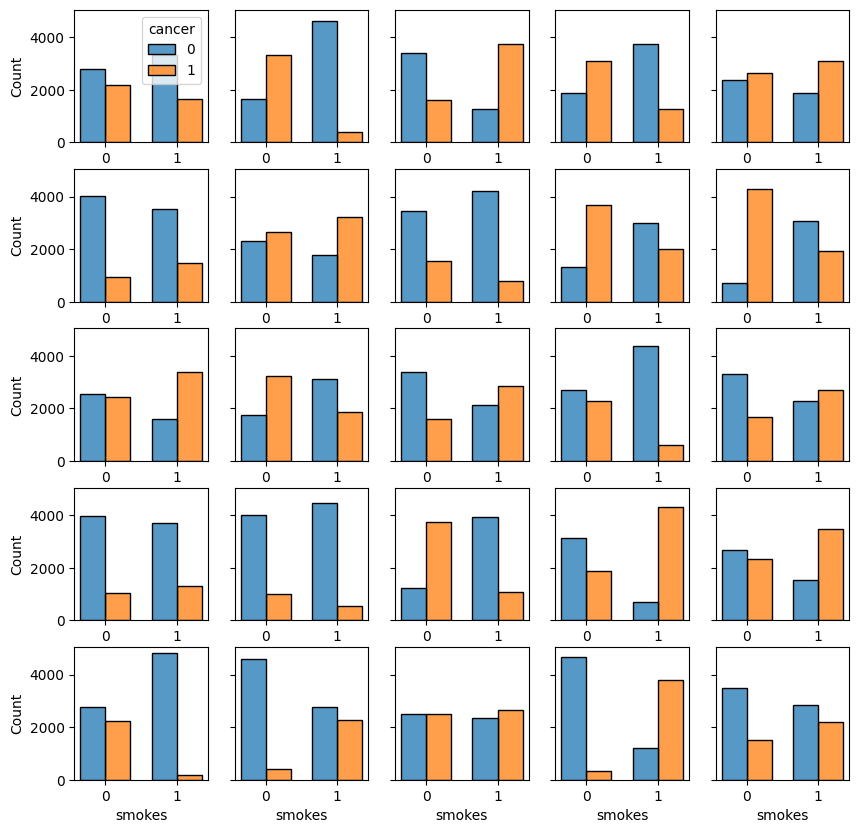

In [94]:
bayesian_always_smokes_model = do(bayesian_observational_model, {"smokes": torch.ones(n_counterfactual_individuals)})
bayesian_never_smokes_model = do(bayesian_observational_model, {"smokes": torch.zeros(n_counterfactual_individuals)})

# NOTE: It's not quite right to say that plates and intervention commute, as the intervention need to be over the full population (see torch.ones above vs. torch.tensor([1.]) previously)
# TODO: refine the language to be more precise (or acknowledge imprecession) about this point.

_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_as, smokes_as, cancer_as = bayesian_always_smokes_model(n_counterfactual_individuals)
    stress_ns, smokes_ns, cancer_ns = bayesian_never_smokes_model(n_counterfactual_individuals)

    data_as = torch.concat((stress_as.reshape(-1, 1), smokes_as.reshape(-1, 1), cancer_as.reshape(-1, 1)), axis=-1)
    data_ns = torch.concat((stress_ns.reshape(-1, 1), smokes_ns.reshape(-1, 1), cancer_ns.reshape(-1, 1)), axis=-1)
    data_int = torch.concat((data_as, data_ns))
    frame_int = pd.DataFrame(data_int.numpy(), columns=["stressed", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_int, ax=ax[row, col], legend = (False if i else True))

In addition to adding prior distribution over model parameters given a known structure, we can further add uncertainty to our causal assumptions
by writing a probabilistic program that selects between multiple probabilistic programs depending on the result of a discrete random choice.
Again, we can quickly expand the complexity of our uncertain causal assumptions without needing to rewrite our original `observational_model` from scratch,
as probabilistic programs in Causal Pyro are compositional.

In the context of our original smoking example, let's pretend that we don't know whether stress causes people to smoke, or whether smoking causes people to become stressed.
Graphically, this would be represented as uncertainty about the causal edge between 'smokes` and 'stress' variables. To implement this uncertainty in Causal Pyro, we 
first need to write a new program that represents the alternative observational model.

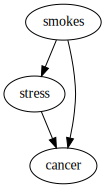

In [96]:
def alternative_observational_model(smokes_pt, stress_cpt, cancer_cpt):
    smokes = pyro.sample("smokes", Bernoulli(smokes_pt)).long()
    stress = pyro.sample("stress", Bernoulli(stress_cpt[smokes])).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

smokes_pt = torch.tensor([0.5])
stress_cpt  = torch.tensor([0.2, 0.8])
cancer_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

pyro.render_model(alternative_observational_model, (smokes_pt, stress_cpt, cancer_cpt))

Again, we can place a prior over parameters for this alternative model, representing our uncertainty about the strength of effects.

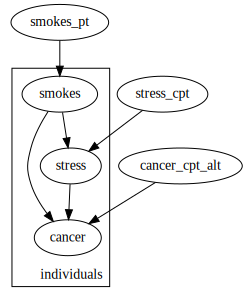

In [112]:
def alternative_parameter_prior():

    smokes_pt = pyro.sample("smokes_pt", Beta(torch.ones(1), torch.ones(1)))
    stress_cpt = pyro.sample("stress_cpt", Beta(torch.ones(2), torch.ones(2)))
    cancer_cpt = pyro.sample("cancer_cpt_alt", Beta(torch.ones(2, 2), torch.ones(2, 2))) 

    return smokes_pt, stress_cpt, cancer_cpt

def bayesian_alternative_observational_model(n_individuals):
    smokes_pt, stress_cpt, cancer_cpt = alternative_parameter_prior()

    with pyro.plate("individuals", n_individuals, dim=-1):
        # Call our original observational_model with parameters sampled from our prior above.
        return alternative_observational_model(smokes_pt, stress_cpt, cancer_cpt)

pyro.render_model(bayesian_alternative_observational_model, (n_individuals,))

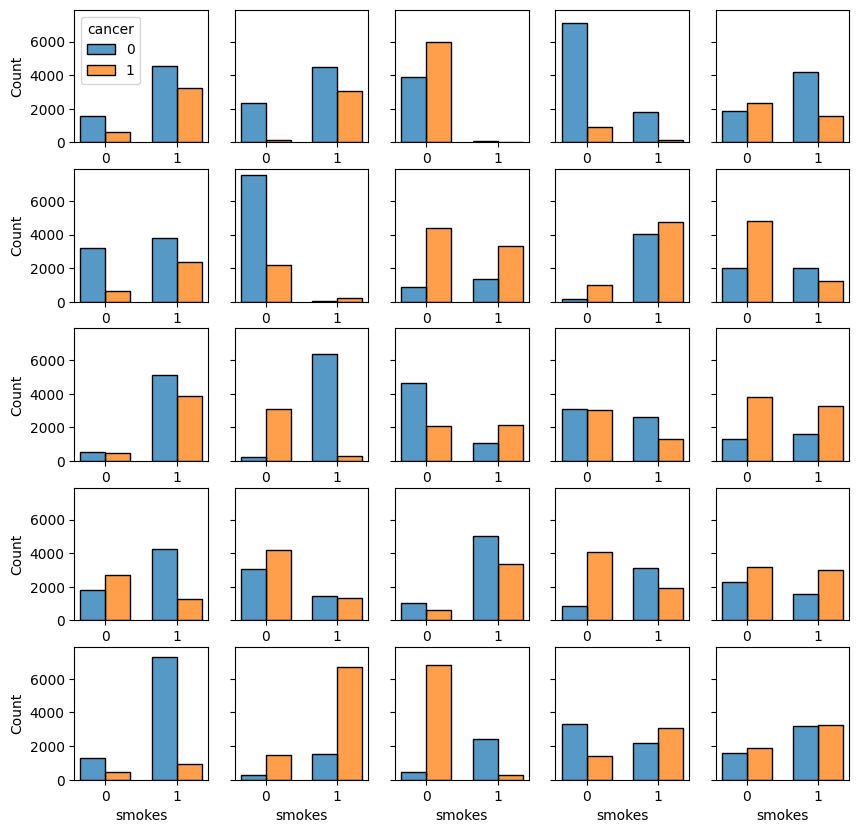

In [99]:
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_alt, smokes_alt, cancer_alt = bayesian_alternative_observational_model(n_individuals)

    data_alt = torch.concat((stress_alt.reshape(-1, 1), smokes_alt.reshape(-1, 1), cancer_alt.reshape(-1, 1)), axis=-1)
    frame_alt = pd.DataFrame(data_alt.numpy(), columns=["stressed", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_alt, ax=ax[row, col], legend = (False if i else True))

Using our two probabilistic programs representing different plausible structures (and with uncertaint parameters), we can write a probabilistic program that randomly chooses between them. 

In [128]:
pyro.sample("t" , Bernoulli(0.5))

tensor(0.)

Provenance:
frozenset({'is_original_model'})
Tensor:
1.0


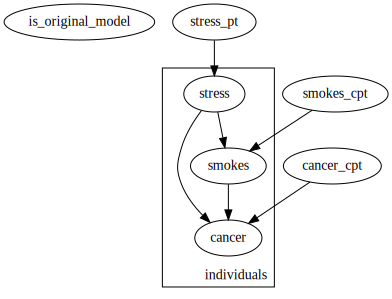

In [142]:
from pyro.distributions import Bernoulli

def bayesian_observational_model_unknown_structure(n_individuals):
    
    is_original_model = pyro.sample("is_original_model", Bernoulli(0.5))
    model = bayesian_observational_model if is_original_model else bayesian_alternative_observational_model
    

    return model(n_individuals)

# I know this is a strange model because of the structure learning. Is there a way to get the rendering to automatically show the mixture?
# It seems like it always samples 1 for `is_original_model`
pyro.render_model(bayesian_observational_model_unknown_structure, (n_individuals,))


Once we have a causal model, what can we use it for? We briefly describe
several problem types that practitioners of causal inference may be
interested in solving (but do not claim that this is an exhaustive
list):

-   **Causal discovery.** Given data (either observational, or collected
    under experimental conditions, or both), infer the underlying causal
    model, from a class of possible models.

-   **Parameter estimation.** Given data (either observational, or
    collected under experimental conditions, or both), and a causal
    model with unknown parameters $\theta$, infer plausible values of
    $\theta$.

-   **Causal effect estimation.** Given data (either observational, or
    collected under experimental conditions, or both), and a causal
    model (possibly with unknown structure or parameters), estimate a
    *causal effect*, e.g. the Average Treatment Effect or the Individual
    Average Treatment Effect. Such queries are designed to answer
    questions like, "On average, how much better would a patient fare if
    they were given one medication vs. another?"

-   **Counterfactual prediction.** Given observed data, and a causal
    model (possibly with unknown structure or parameters), estimate a
    *counterfactual query*, designed to answer questions like, "Given
    what we know about this patient (including their observed health
    outcome), how would their outcome have differed had we treated them
    differently?"

All of these questions can be posed in a Bayesian framework. In particular, 
causal discovery, parameter estimation, causal effect estimation, and counterfactual prediction can be framed as Bayesian inference in appropriately specified generative models.


The quantities over which we have uncertainty are:

-   the structure of the true causal model,

-   the parameters of the true causal model, and

-   the values of any latent variables posited by the true causal model,
    for each subject in our dataset. (In the presence of experimental
    data, we are also uncertain about the latent variables posited by
    the intervened version of the true causal model, for each subject in
    the experimental dataset.)

We can express priors over these quantities, and likelihoods that relate
them to the observations. For example, suppose we are uncertain about
the true model structure $m$, and its unknown parameters $\theta$, as
well as the values of latent variables $x$, but we have observed $y$ for
a number of subjects, indexed $j = 1, \dots, N$. Then the likelihood for
$y_j$ is $p(y_j \mid m, \theta, x_j) = m_\theta(y_j \mid x_j)$. If we
also have observations $y'$ from an experimental setting modeled by
intervention $i$, then the likelihood is
$p(y'_j \mid m, \theta, x_j) = \text{intervene}(m_\theta, i)(y'_j \mid x_j)$.

Having expressed a prior and a likelihood, posterior inference can
recover causal structures $m$ and parameters $\theta$. Causal effects
and counterfactuals can be estimated by introducing additional variables
representing hypothetical *potential outcomes*. Such constructions might
usefully be automated by probabilistic programming languages, at which
point existing PPL inference machinery could be applied to estimating
the posterior.


## Observation 3: causal inference is probabilistic inference

Bayesian causal inference places identifiability on a principled continuum of irreducible causal uncertainty.

On the surface, to claim that causal reasoning can be encapsulated by
probabilistic computation appears to be in direct conflict with Pearl's
insistence that causal and statistical concepts be kept
separate [@pearl2001bayesian]. As Pearl describes them, statistical
concepts are those that summarize the distribution over observed
variables.

The probabilistic computations that we discuss in this
documentation are different in-kind from these assumption-free
summaries of data, in that we aim compute to probabilities of *latent*
causal structure, effects, and counterfactuals. In our proposed
approach, causal probabilistic programs play the role of causal
assumptions, relating observations to the latent causal quantities of
interest.

Casting causal inference as a particular instantiation of probabilistic
inference does not change the reality that many causal conclusions
cannot be unambiguously identified from data, regardless of sample size.
How much of the mutual information between treatment and outcome is
attributable to latent confounding? Does A cause B or does B cause A? If
C were c, what would have happened to D? Answers to all of these
questions are often ambiguous. 

Surprisingly, most existing formulations
of causal inference avoid quantifying these uncertainties, instead
abandoning problems in which latent causal quantities cannot be uniquely
inferred from data.[^2] Instead, the probabilistic programming approach
we espouse here enables users to express their assumptions, compute the
resulting uncertainty, be it irreducible or not, and then make decisions
accordingly.

## A Causal Bayesian Workflow